# Exercise 4 - DDPG
Prof. Joschka Bödecker, Julien Brosseit, Erfan Azad

In this exercise we will train our own agent using [Deep Deterministic Policy Gradient](https://arxiv.org/pdf/1509.02971.pdf) (DDPG) to safely land a lunarlander from [Gymnasium environments](https://gymnasium.farama.org/environments/box2d/lunar_lander/). Previously we looked at the DQN algorithm which works for discrete action spaces. Many real world scenarious, such as robotics or self-driving cars, require the agent/controller to perform on a continuous action space. So it is time to move from discrete world to a continuous world! 

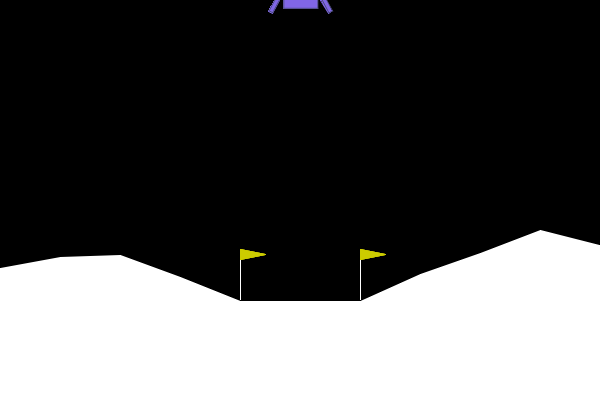

<!--  -->
_Agent using random actions to land the lunarlander_

Exercises are clearly marked as <span style="color:orange">**EXERCISE**</span>. Answer concisely, otherwise points will be deducted!

## 0 Setup
In addition to the packages from the last exercise, we also install `gymnasium[box2d]` for the Lunar Lander environment:

In [1]:
!pip install torch
!pip install gymnasium
!pip install "gymnasium[box2d]"
!pip install matplotlib
!pip install imageio

In [2]:
# Imports
from typing import Iterable
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import copy
import numpy as np
import pandas as pd
import random
from PIL import Image
import gymnasium as gym
import matplotlib.pyplot as plt
from typing import Callable
from collections import namedtuple
import itertools

## 1 Deep Deterministic Policy Gradient (DDPG)

For another introduction to DDPG, we recommend the introduction by [Spinning Up](https://spinningup.openai.com/en/latest/algorithms/ddpg.html).

### 1.1 Motivation 

As we have seen in the last exercise, Deep Q-Networks have difficulties in continuous action spaces because choosing the greedy action: $max_a Q(s,a)$ becomes a hard 
optimisation problem due to the infinite number of actions.



DDPG solves this problem by introducing a deterministic policy $μ(s)$ (also called _Actor_) that tries to learn the optimal action such that 
$μ(s) \approx argmax_a Q(s,a)$. 
Thus we do not have to solve the optimisation problem anymore! But how do we learn $μ(s)$?

### 1.2 Determinitic Policy Gradient (DPG)

First, we represent our actor as a neural network $\mu_\phi$ with weights $\phi$. Initially, the actions returned by it are relatively random due to random initialisation. Now imagine that we have already trained a Q-function $Q_\theta$ using another neural network (we will explain exactly how later). Our goal is that $\mu$ will select the optimal action $a*$ for a given state $s$, as shown in the figure.

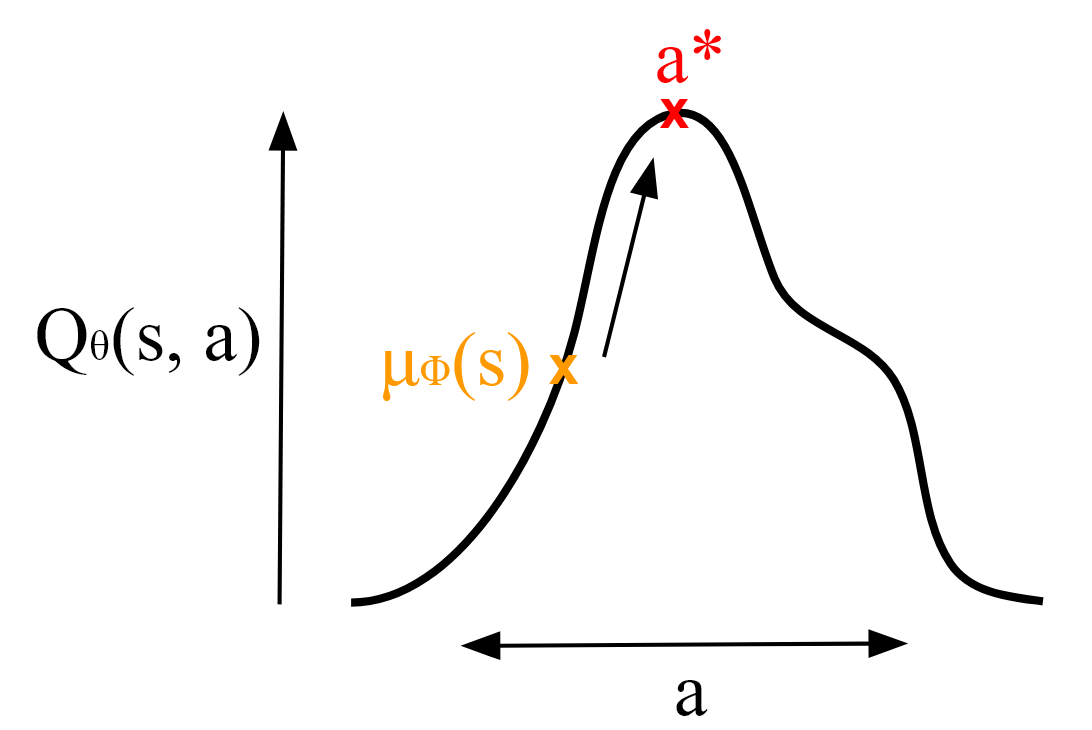

This is an optimisation problem, and there are many ways to solve it. However, we observe that $Q_\theta$ is a neural network, and these are _differentiable_. So our objective function is differentiable, and we can use gradient ascent to optimise $\mu_\phi$ so that it selects actions that lead to higher Q-values. We call the resulting gradient the Deterministic Policy Gradient (DPG) (without Deep), which was proposed in this [paper](https://proceedings.mlr.press/v32/silver14.pdf). It is given by:

$\nabla_\phi J(\phi) = E_{s\sim D}[\nabla_\phi \mu_\phi(s) \nabla_a Q_\theta(s, a) | a =\mu_\phi(s)]$

with $D$ as some state distribution.
We differentiate not only through our actor $\mu$, but also through our learned Q-function. 
_Bonus remark_: For those familiar with Generative Adversarial Networks, the idea has shallow similarity in that we also adjust our generator (Actor) using gradient information from the discriminator (Q-function), neat!

---
<span style="color:orange">**EXERCISE**</span>: **DDPG Warm-up**

1. In DDPG the actor is deterministic, why could this be a problem if we want to sample experience with it?
2. In DQN, the Q-network would only take the observation as input and output Q-values for each of the actions. What should the input and outputs be for the Q-network in continuous settings?
3. We assume that our Q-function is correct. Name one problem that may arise for the actor if we use a neural network to represent our Q-function.
4. You have now heard how DDPG solves the problem with continuous action spaces. Can you think of an idea how to _DQNs_ could work in continuous action spaces?
5. What could be a potential short coming of your suggested approach above? 

**Your answers here:**...

1.Deterministic actor generates the same action for a given state. Without adequate exploration, the replay buffer will lack diverse experiences, causing the policy to converge to suboptimal behaviors.

2.In continuous the Q-network takes both the observation and the action as inputs and outputs a scalar representing the Q-value.

3.One of the problems that may arise is it may be non smooth or non convex in the action space. Problems may arise while the actor tries to optimize the policy.

4.To make DQNs work for continuous action spaces, one  approach is to discretize the continuous action space.

5.One of the potential short coming might be that it looses control of the continuous control and perform poorly in high-dimensional action space.

## 2 Q-function (Critic)
As in DQNs, we represent our Q-function (also called _Critic_) by a deep neural network (hence the name in Deep DPG). 
Since we learn an actor $\mu$ and a critic $Q$, DDPG is called an _actor-critic_ method.

---
<span style="color:orange">**EXERCISE**</span>: **Implementing the Critic**

In this exercise, you will implement a critic model that uses single dimension-based observations (not image-based like last time). The model takes both the observation and action as input and outputs a Q-value. Its architecture consists of three linear layers with ReLU activations:
- fc1: Input size = (obs_dim + action_dim), Output size = 256
- fc2: Input size = 256, Output size = 256
- fc3: Input size = 256, Output size = 1

Implement this architecture.

In [3]:
class Critic(nn.Module):
    def __init__(self, obs_dim: int, action_dim: int):
        """
        Initialize the Critic network.
        
        :param obs_dim: dimention of the observations
        :param num_actions: dimention of the actions
        """
        super(Critic, self).__init__()

        # TODO: your code
        #raise NotImplementedError()
        self.fc1 = nn.Linear(obs_dim + action_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)


    def forward(self, obs: torch.Tensor, action: torch.Tensor) -> torch.Tensor:
        # TODO: your code
        #raise NotImplementedError()
        x = torch.cat((obs,action),1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [4]:
# Test the network
obs_dim = 3
action_dim = 2

critic = Critic(obs_dim, action_dim)
obs = torch.randn(32, obs_dim)
action = torch.randn(32, action_dim)

out = critic(obs, action)
assert out.shape == (32, 1), out.shape

### 2.1 Training the Critic
The Q-function is learned similar to DQN, but since maximizing $Q$ is difficult, we now instead take the actor $\mu$ which changes the target to:

$ y = r + \gamma Q_\theta(s', μ(s'))$.

Again, we minimize the Mean Squared Error Loss between td-target and prediction via gradient descent: $ L(\theta) = \mathop{{}\mathbb{E}}_{(s, a, r, s') \sim D}([y - Q_\theta(s, a)]^2 )$.

<span style="color:orange">**EXERCISE**</span>: **Implementing the Critic Update**

Write the function ``update_critic``, which gets the sampled data from the replay buffer, calculates the loss and updates for one optimizer step. For the target calculation, use the actor and critic target networks, respectively. You can expect ``actor_target`` to be a PyTorch neural network that returns a batch of actions given a batch of observations.

In [7]:
def update_critic(
        actor_target: nn.Module,
        critic: nn.Module,
        critic_target: nn.Module,
        optimizer: optim.Optimizer,
        gamma: float,
        obs: torch.Tensor,
        act: torch.Tensor,
        rew: torch.Tensor,
        next_obs: torch.Tensor,
        tm: torch.Tensor,
    ):
    """
    Update the DDPG's Critic network for one optimizer step using the target networks and the formula from above.

    :param actor_target: The target actor network.
    :param critic: The critic network.
    :param critic_target: The target critic network.
    :param optimizer: The critic's optimizer.
    :param gamma: The discount factor.
    :param obs: Batch of current observations from the replay buffer.
    :param act: Batch of actions.
    :param rew: Batch of rewards.
    :param next_obs: Batch of next observations.
    :param tm: Batch of termination flags.

    """
    # TODO: Zero out the gradient
    #raise NotImplementedError()
    optimizer.zero_grad()

    with torch.no_grad():
        # TODO: Calculate the actions using the actor
        #raise NotImplementedError()
        nxt_act = actor_target(next_obs)

        # TODO: Calculate the TD-Target using the actions
        #raise NotImplementedError()
        nxt_q = critic_target(next_obs, nxt_act)
        td_target = rew + gamma * nxt_q * (1 - tm.float())

    # TODO: Calculate the loss. Note, the critic now works differently than last time!
    #raise NotImplementedError()
    obs_q  = critic(obs, act)
    loss = nn.MSELoss()(td_target.float().detach(), obs_q.float())

    # TODO: Backpropagate the loss and step the optimizer
    #raise NotImplementedError()
    loss.backward()
    optimizer.step()

In [8]:
# Self-test for the critic update
obs_dim = 3
action_dim = 2
critic = Critic(obs_dim, action_dim)
critic_target = copy.deepcopy(critic)
actor_target = nn.Linear(obs_dim, action_dim)
optimizer = optim.Adam(critic.parameters(), lr=1e-3)
obs = torch.randn(32, obs_dim)
act = torch.randn(32, action_dim)
rew = torch.randn(32, 1)
next_obs = torch.randn(32, obs_dim)
tm = torch.zeros(32, 1)

# This should not throw any errors!
update_critic(actor_target, critic, critic_target, optimizer, 0.99, obs, act, rew, next_obs, tm)

<span style="color:orange">**EXERCISE**</span>: **DDPG Questions**
1. In Exercise 2 we looked at the expected SARSA update. How does the DDPG critic update relate to it?
2. Why is the use of a target network useful for the actor?

**Your answers here:**...

1.Expected SARSA uses the expected Q-value under a stochastic policy as its target, while DDPG directly uses the deterministic action from the actor for the next state.

2.The use of a target network is useful for the actor because it provides stability and smoother updates during training. Also reduces the risk of divergence while training.

# 3 Policy (Actor) 
Like the critic, the actor is also explicitly represented by a neural network. 

---
<span style="color:orange">**EXERCISE**</span>: **Implementing the Actor**

Implement the actor network with the following architecture:
- fc1: input size = (obs_dim), output size = 256
- fc2: input size = 256, output size = 256
- fc3: input size = 256, output size = action_dim

_Note_: The output of the last layer should pass through a tanh (not ReLU) activation and be scaled and translated according to the action space of the environment. The tanh activation restricts the actions to the $[-1,1]$ range and the scaling and translation ensures that the action is within the boundaries of the environment's action space. Use `action_scale` and `action_bias` for this.

In [9]:
class Actor(nn.Module):
    def __init__(self, obs_dim: int, action_dim: int, action_low: np.array, action_high: np.array):
        """
        Initialize the Actor network.
        
        :param obs_dim: dimention of the observations
        :param action_dim: dimention of the actions
        :param action_low: the lower bound of the action space
        :param action_high: the upper bound of the action space
        """
        super(Actor, self).__init__()
        # We are registering scale and bias as buffers so they can be saved and loaded as part of the model.
        # Buffers won't be passed to the optimizer for training!
        self.register_buffer(
            "action_scale", torch.tensor((action_high - action_low) / 2.0, dtype=torch.float32)
        )
        self.register_buffer(
            "action_bias", torch.tensor((action_high + action_low) / 2.0, dtype=torch.float32)
        )
        # TODO: your code
        #raise NotImplementedError()
        self.fc1 = nn.Linear(obs_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, action_dim)


    def forward(self, obs: torch.Tensor) -> torch.Tensor:
        # TODO: your code
        #raise NotImplementedError()
        x = torch.relu(self.fc1(obs))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        x = torch.tanh(x) * self.action_scale + self.action_bias
        return x

In [10]:
# Actor Tests
obs_dim = 3
action_dim = 2
action_low = np.array([2, 2])
action_high = np.array([2, 2])

actor = Actor(obs_dim, action_dim, action_low, action_high)
obs = torch.randn(2, obs_dim)
action = actor(obs)
assert action.shape == (2, action_dim)
assert torch.abs(action.detach() - torch.tensor([[2, 2], [2, 2]]).float()).sum() < 1e-5

<span style="color:orange">**EXERCISE**</span>: **Implementing the Actor Update**

Write the function ``update_actor``, which gets the sampled data from the replay buffer, calculates the loss as shown in the introduction to DDPG and updates for one optimizer step.

_Hint 1_: The objective can be approximated by: $J(\phi) = \frac{1}{n} \sum^n_{i=1} Q_\theta(s_i, \mu_\phi(s))$. If written in this way, PyTorch can _automatically_ differentiate through it via `.backward()` leading to the DPG gradient.

_Hint 2_: PyTorch always minimizes its objectives with `optimizer.step()`, but we want to maximize the objective! How do we achieve that?


In [11]:
def update_actor(actor: nn.Module,
                 optimizer: optim.Optimizer,
                 critic: nn.Module,
                 obs: torch.Tensor):
    """
    Update the DDPG's Actor network for one optimizer step.

    :param actor: The actor network.
    :param optimizer: The actor's optimizer.
    :param critic: The critic network.
    :param obs: Batch of current observations.
    """
    # TODO: Zero out the gradient
    #raise NotImplementedError()
    optimizer.zero_grad()

    ### TODO: Do a forward pass through the actor to get the actions
    #raise NotImplementedError()
    actions = actor(obs)

    # TODO: Calculate the DPG loss
    #raise NotImplementedError()
    loss = -critic(obs, actions).mean()

    # TODO: Backpropagate the loss and step the optimizer
    #raise NotImplementedError()
    loss.backward()
    optimizer.step()

# 4 Replay Buffer & Target Networks

In the last sections, we discussed the loss for critic and actor. As seen in DQNs, these losses are unstable. That's why we use the two techniques from the last exercise: _target networks_ and a _replay buffer_ to stabilise the training. We import the replay buffer from the previous exercise:

In [12]:
class ReplayBuffer:
    def __init__(self, max_size):
        self.data = []
        self.max_size = max_size
        self.position = 0

    def __len__(self):
        return len(self.data)

    def store(self, obs, action, reward, next_obs, terminated):
        if len(self.data) < self.max_size:
            self.data.append((obs, action, reward, next_obs, terminated))
        else:
            self.data[self.position] = (obs, action, reward, next_obs, terminated)   
        self.position = (self.position + 1) % self.max_size       

    def sample(self, batch_size):
        return [torch.stack(b) for b in zip(*random.choices(self.data, k=batch_size))]

<span style="color:orange">**EXERCISE**</span>: **Implementing the Soft-Target Update**

In the DQN exercise we have seen _hard_ target updates. In DDPG we use a different strategy called _soft_ target updates. Instead of copying the parameters completely, we use a linear combination of old and new parameters:

$(1-\tau)*$ target_params $ + \tau*$ params

with $\tau \in [0, 1]$ as hyperparameter. This can further increase the stability of the algorithm, as targets change more slowly.
For $\tau = 1$ we have the hard updates. Implement the soft update.

In [13]:
def soft_update(
    params: Iterable[torch.Tensor],
    target_params: Iterable[torch.Tensor],
    tau: float,
):
    """
    Perform a soft update also called polyak average on ``target_params`` using ``params``:

    :param params: parameters of the original network (model.parameters())
    :param target_params: parameters of the target network (model_target.parameters())
    :param tau: the soft update coefficient ("Polyak update", between 0 and 1) 1 -> Hard update, 0 -> No update
    """
    with torch.no_grad():
        # TODO: implement soft update. target_param <--- (1-tau)*target_param + tau*param
        #raise NotImplementedError()
        for target_param, param in zip(target_params, params):
            torch.add(target_param.data.mul_(1 - tau), param.data.mul_(tau))

# 5 Algorithm
We are now putting it all together. This implementation is very similar to the DQN implementation. One interesting point we haven't covered yet is how we sample experience using a deterministic policy. To do this, we use a little trick of adding some normally distributed noise to the action output. This is already implemented.

---
<span style="color:orange">**EXERCISE**</span>: **Implementing the DDPG Agent**

Implement the DDPG agent by filling in the missing gaps in the code.

In [14]:
EpisodeStats = namedtuple("Stats", ["episode_lengths", "episode_rewards"])

class DDPGAgent:
    def __init__(self,
            env,
            exploration_noise=0.1,
            gamma=0.99,
            lr=0.001, 
            batch_size=64,
            tau=0.005,
            maxlen=100_000,
        ):
        """
        Initialize the DDPG agent.

        :param env: The environment.
        :param exploration_noise.
        :param gamma: The discount factor.
        :param lr: The learning rate.
        :param batch_size: Mini batch size.
        :param tau: Polyak update coefficient.
        :param max_size: Maximum number of transitions in the buffer.
        """

        self.env = env
        self.exploration_noise = exploration_noise
        self.gamma = gamma
        self.batch_size = batch_size
        self.tau = tau

        # TODO: Initialize the Replay Buffer
        #raise NotImplementedError()
        self.replay_buffer = ReplayBuffer(maxlen)

        # TODO: Initialize the Critic and Actor networks
        #raise NotImplementedError()
        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]
        self.critic = Critic(obs_dim,action_dim)
        self.actor = Actor(obs_dim,action_dim, env.action_space.low, env.action_space.high)

        # TODO: Initialize the target Critic and Actor networks and load the corresponding state_dicts
        #raise NotImplementedError()
        self.critic_target = Critic(obs_dim,action_dim)
        self.actor_target = Actor(obs_dim,action_dim, env.action_space.low, env.action_space.high)
        
        # TODO: Create ADAM optimizer for the Critic and Actor networks
        #raise NotImplementedError()
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr)


    def train(self, num_episodes: int) -> EpisodeStats:
        """
        Train the DDPG agent.

        :param num_episodes: Number of episodes to train.
        :returns: The episode statistics.
        """
        # Keeps track of useful statistics
        stats = EpisodeStats(
            episode_lengths=np.zeros(num_episodes),
            episode_rewards=np.zeros(num_episodes),
        )
        current_timestep = 0

        for i_episode in range(num_episodes):
            # Print out which episode we're on, useful for debugging.
            if (i_episode + 1) % 100 == 0:
                print(f'Episode {i_episode + 1} of {num_episodes}  Time Step: {current_timestep}')

            # Reset the environment and get initial observation
            obs, _ = self.env.reset()
            
            for episode_time in itertools.count():
                # Choose action and execute
                with torch.no_grad():
                    action = self.actor(torch.as_tensor(obs).float())
                    # Add noise to the action and clamp the value to make sure it is within the action_space bounds
                    action += torch.normal(0, self.actor.action_scale * self.exploration_noise)
                    action = action.cpu().numpy().clip(self.env.action_space.low, self.env.action_space.high)
                next_obs, reward, terminated, truncated, _ = self.env.step(action)

                # Convert to tensors
                obs = torch.as_tensor(obs).float()
                action = torch.as_tensor(action).float()
                next_obs = torch.as_tensor(next_obs).float()
                reward = torch.as_tensor([reward])
                terminated = torch.as_tensor([terminated])
                truncated = torch.as_tensor([truncated])

                # Update statistics
                stats.episode_rewards[i_episode] += reward
                stats.episode_lengths[i_episode] += 1

                # TODO: Store sample in the replay buffer
                #raise NotImplementedError()
                self.replay_buffer.store(obs, action, reward, next_obs, terminated)

                # TODO: Sample a mini batch from the replay buffer
                #raise NotImplementedError()
                obs_batch, act_batch, rew_batch, next_obs_batch, tm_batch  = self.replay_buffer.sample(self.batch_size)

                # Update the Critic network
                update_critic(
                    self.actor_target,
                    self.critic,
                    self.critic_target,
                    self.critic_optimizer,
                    self.gamma,
                    obs_batch.float(),
                    act_batch.float(),
                    rew_batch.float(),
                    next_obs_batch.float(),
                    tm_batch.float(),
                )
                # Update the Actor network
                update_actor(
                    self.actor,
                    self.actor_optimizer,
                    self.critic,
                    obs_batch.float(),
                )

                # Update the target networks via Polyak Update
                soft_update(self.critic.parameters(), self.critic_target.parameters(), self.tau)
                soft_update(self.actor.parameters(), self.actor_target.parameters(), self.tau)
                
                current_timestep += 1

                # Check whether the episode is finished
                if terminated or truncated or episode_time >= 500:
                    break
                obs = next_obs
        return stats

# 6 Training

Now, we want to run our algorithm on the Lunar Lander task from [Gymnasium environments](https://gymnasium.farama.org/environments/box2d/lunar_lander/).
Note, that the training can take quite some time and can be unstable.

In [19]:
# Choose your environment
env = gym.make("LunarLander-v2", continuous = True, render_mode="rgb_array")

# Print observation and action space infos
print(f"Training on {env.spec.id}")
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}\n")

# Hyperparameters, Hint: Change as you see fit
LR = 0.005
BATCH_SIZE = 64
REPLAY_BUFFER_SIZE = 500_000
TAU = 0.005
EXPLORATION_NOISE=0.2
NUM_EPISODES = 2000
DISCOUNT_FACTOR = 0.99

# Train DDPG
agent = DDPGAgent(
    env, 
    exploration_noise=EXPLORATION_NOISE,
    gamma=DISCOUNT_FACTOR,
    lr=LR,
    batch_size=BATCH_SIZE,
    tau=TAU,
    maxlen=REPLAY_BUFFER_SIZE,
)
stats = agent.train(NUM_EPISODES)

Training on LunarLander-v2
Observation space: Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)
Action space: Box(-1.0, 1.0, (2,), float32)

Episode 100 of 2000  Time Step: 10032
Episode 200 of 2000  Time Step: 19667
Episode 300 of 2000  Time Step: 29379
Episode 400 of 2000  Time Step: 39565
Episode 500 of 2000  Time Step: 49326
Episode 600 of 2000  Time Step: 59235
Episode 700 of 2000  Time Step: 68988
Episode 800 of 2000  Time Step: 79177
Episode 900 of 2000  Time Step: 89519
Episode 1000 of 2000  Time Step: 99249
Episode 1100 of 2000  Time Step: 108628
Episode 1200 of 2000  Time Step: 118011
Episode 1300 of 2000  Time Step: 127826
Episode 1400 of 2000  Time Step: 137771
Episode 1500 of 2000  Time Step: 147571
Episode 1600 of 2000  Time Step: 157310
Episode 1700 of 2000  Time Step: 167240
Episode 1800 of 2000  Time Step: 177350
Episode 1900 of 2000  Time 

# 7 Results

Like in the last exercise, we will look at the resulting episode reward.

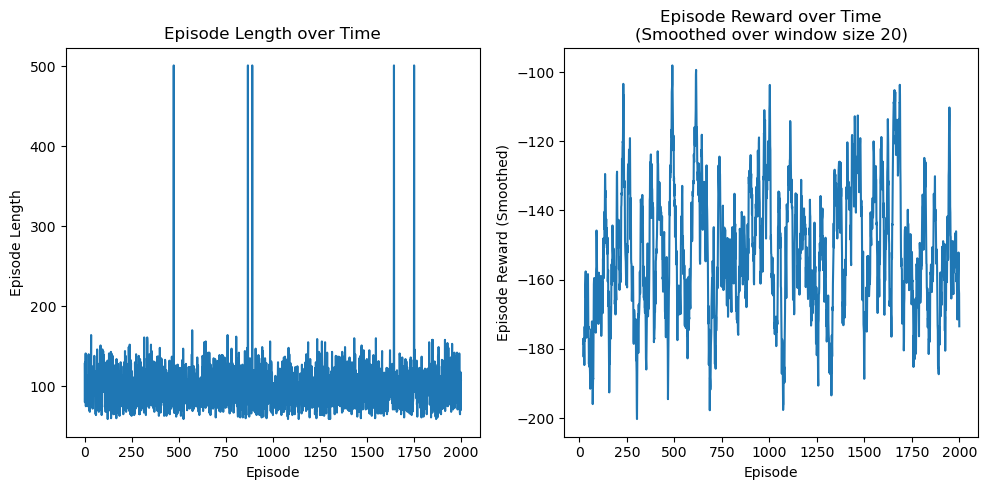

In [20]:
smoothing_window=20
fig, axes = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)

# Plot the episode length over time
ax = axes[0]
ax.plot(stats.episode_lengths)
ax.set_xlabel("Episode")
ax.set_ylabel("Episode Length")
ax.set_title("Episode Length over Time") 

# Plot the episode reward over time
ax = axes[1]
rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
ax.plot(rewards_smoothed)
ax.set_xlabel("Episode")
ax.set_ylabel("Episode Reward (Smoothed)")
ax.set_title(f"Episode Reward over Time\n(Smoothed over window size {smoothing_window})")
plt.show()

Lastly, let us see what the learned policy does in action.

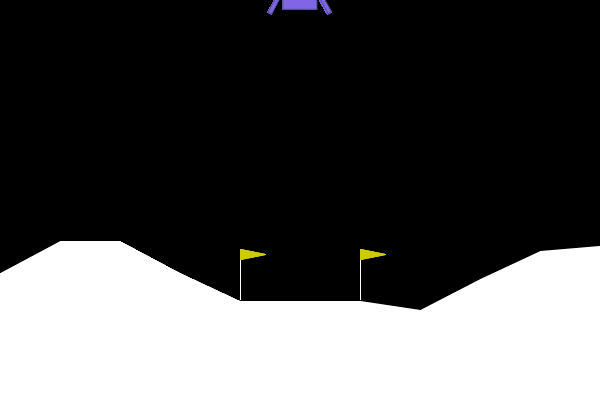

In [21]:
from IPython.display import Image as IImage

def save_rgb_animation(rgb_arrays, filename, duration=50):
    """Save an animated GIF from a list of RGB arrays."""
    # Create a list to hold each frame
    frames = []

    # Convert RGB arrays to PIL Image objects
    for rgb_array in rgb_arrays:
        rgb_array = (rgb_array).astype(np.uint8)
        img = Image.fromarray(rgb_array)
        frames.append(img)
    
    # Save the frames as an animated GIF
    frames[0].save(filename, save_all=True, append_images=frames[1:], duration=duration, loop=0)

def rendered_rollout(policy, env, max_steps=1_000):
    """Rollout for one episode while saving all rendered images."""
    obs, _ = env.reset()
    imgs = [env.render()]

    for _ in range(max_steps):
        with torch.no_grad():
            action = policy(torch.as_tensor(obs, dtype=torch.float32)).cpu().numpy()
            
        obs, _, terminated, truncated, _ = env.step(action)
        imgs.append(env.render())
        
        if terminated or truncated:
            break

    return imgs

actor = agent.actor
actor.eval()
imgs = rendered_rollout(actor, env)
save_rgb_animation(imgs, "trained.gif")
IImage(filename="trained.gif")

We did not train very far because it can be very time-consuming.

---
<span style="color:orange">**EXERCISE**</span>: **Over Estimation Bias**

1. One of the common issues with Q-Learning based algorithms is the Over Estimation Bias. Explain in detail what is over estimation bias and the reason behind it. 
2. One of the algorithms that extends DDPG is Twin Delayed DDPG also called [TD3](https://arxiv.org/pdf/1802.09477.pdf), what strategy did they employ to address the over estimation bias? Remark: TD3 is a possible group project topic!

**Your answers here:**...

1.Over estimation bias is when the estimated Q-values is higher than the true Q-values. This leads to suboptimal learning. This occurs as the max operation amplifies the noise and errors in Q-Value prediction.

2.TD3 uses Clipped Double Q-Learning, an extension of Double Q-Learning,which leverages on that a value estimate suffering from overestimation bias can be used as an approximate upper-bound to the true value estimate. This favors underestimations, which do not tend to be propagated during learning, as actions with low value estimates are avoided by the policy. This approach ensures more reliable Q-value estimates, which stabilize both the critic and actor training

---
<span style="color:orange">**FEEDBACK**</span>

Describe your experience with this exercise and the course. We have set up an anonymous option for this in ILIAS or you can write your feedback directly here in the notebook.